**Tianyi Wan; Guoli Rao; Shengbo Lang**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve

import warnings
warnings.filterwarnings('ignore')

### Q1 Q2

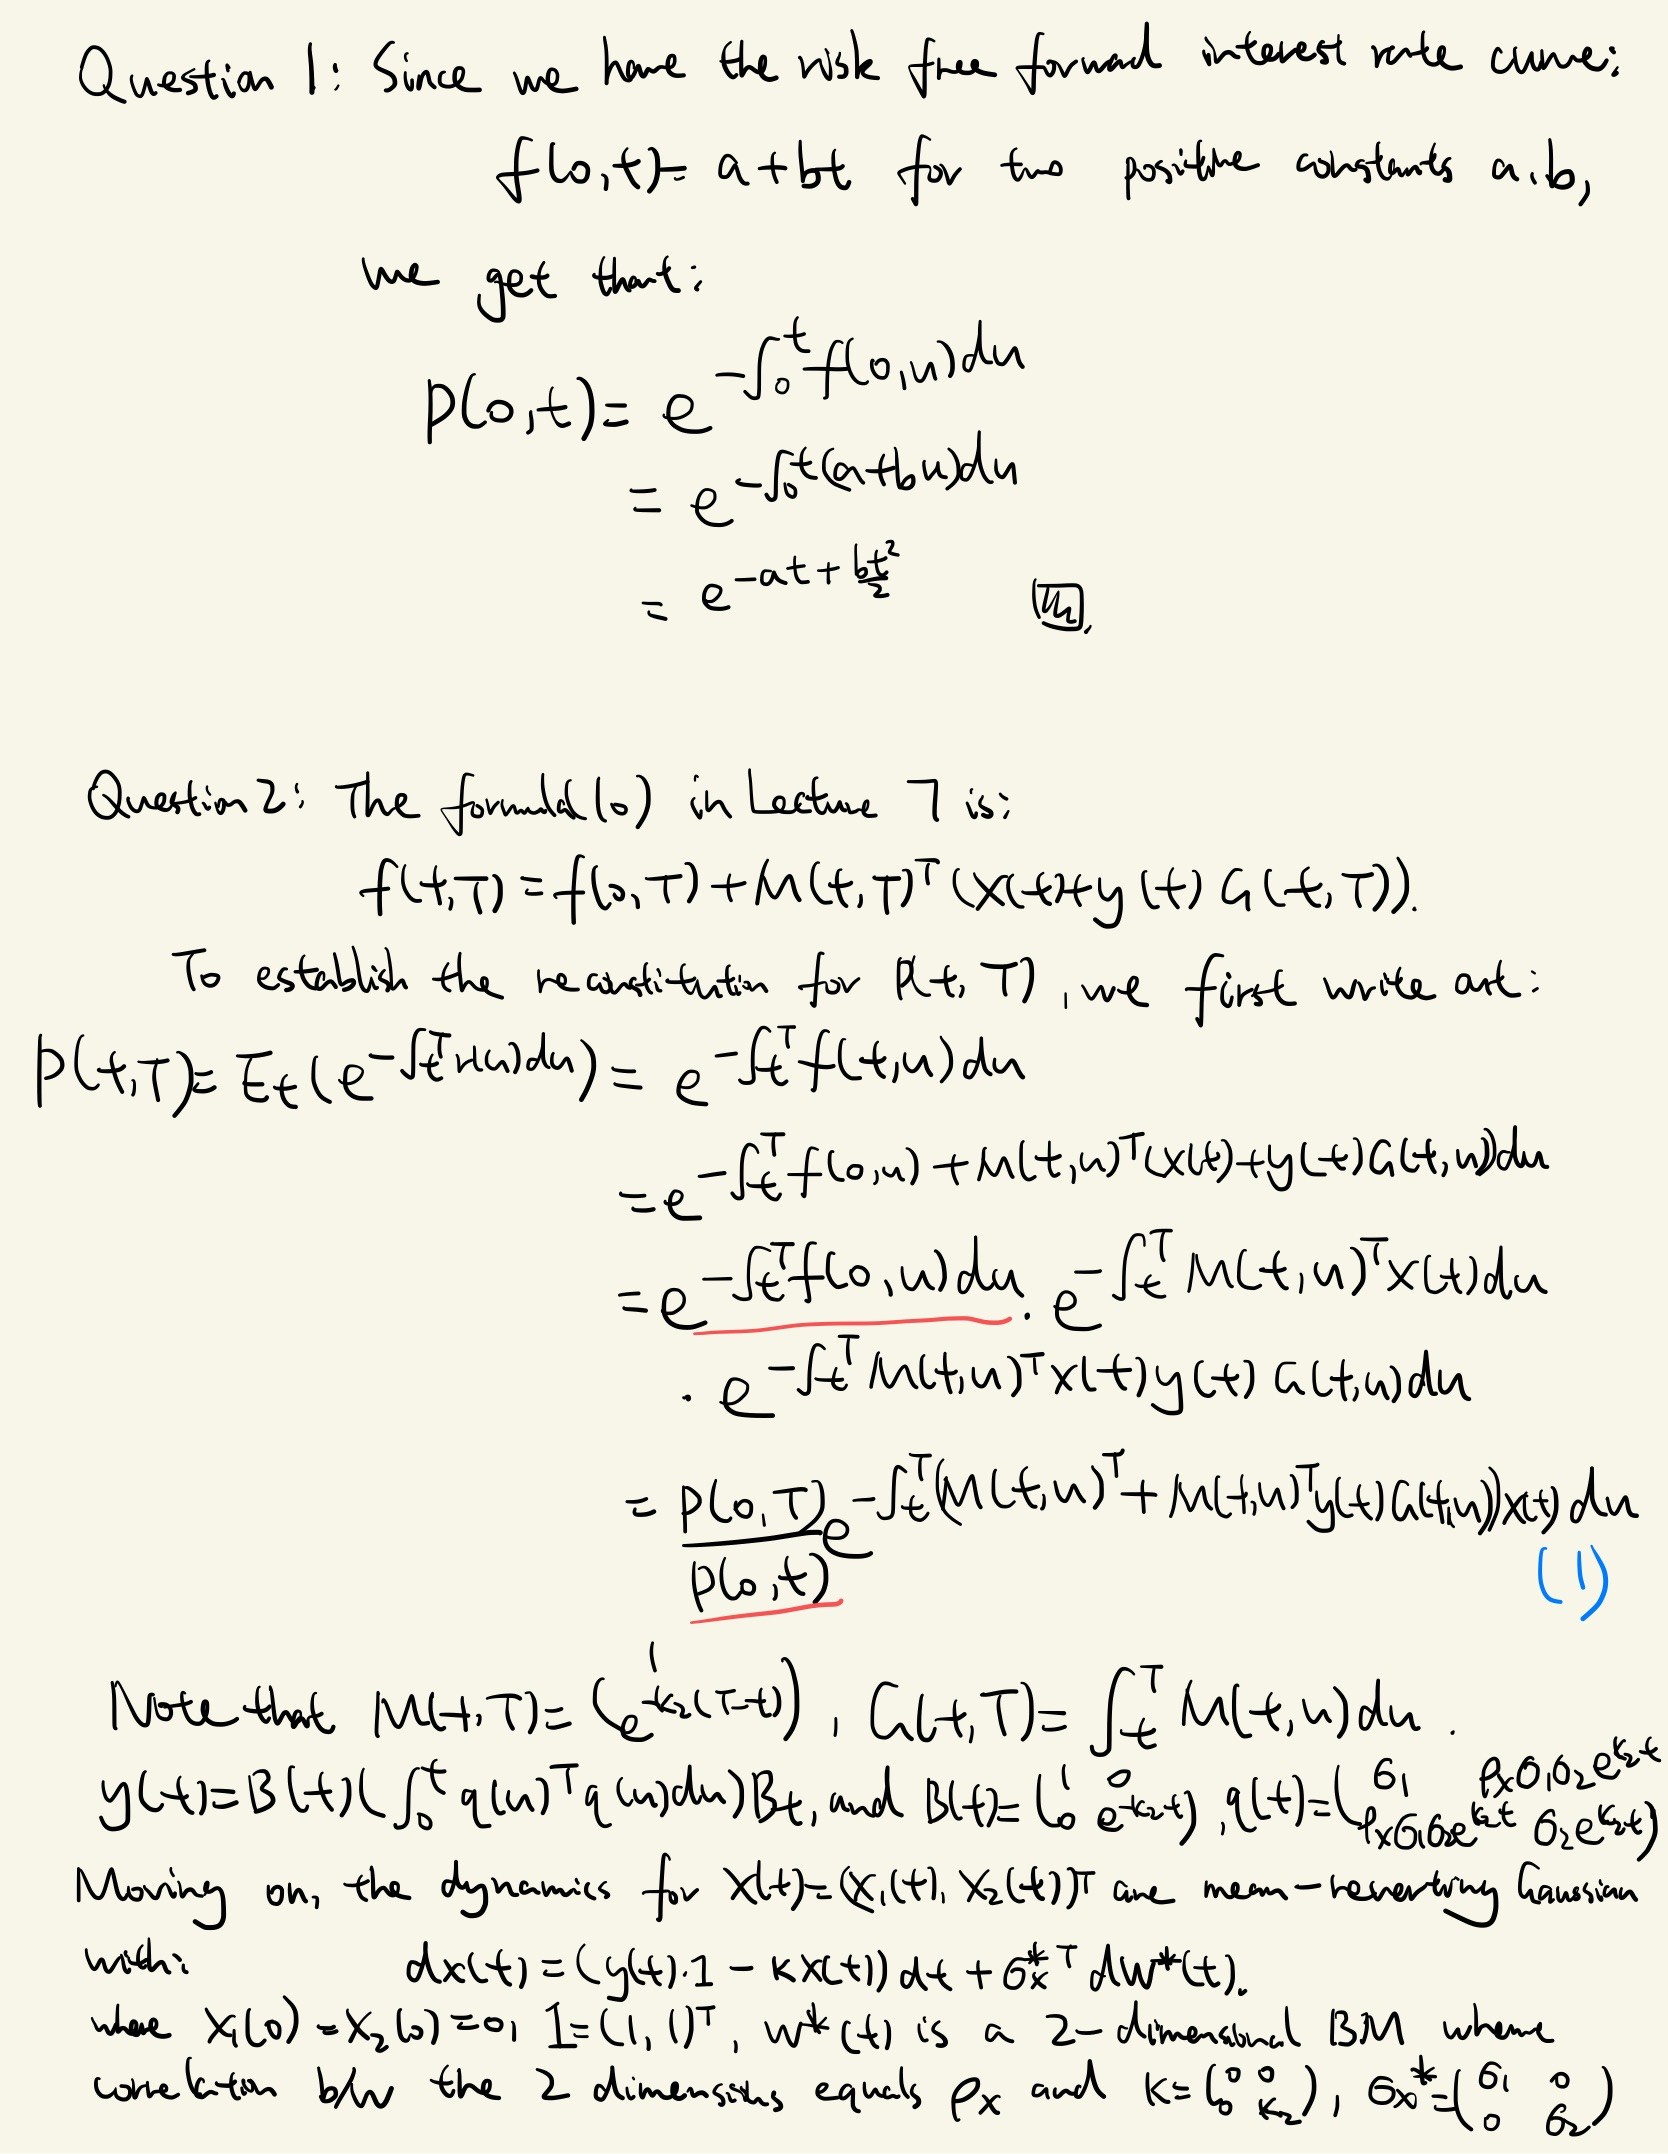

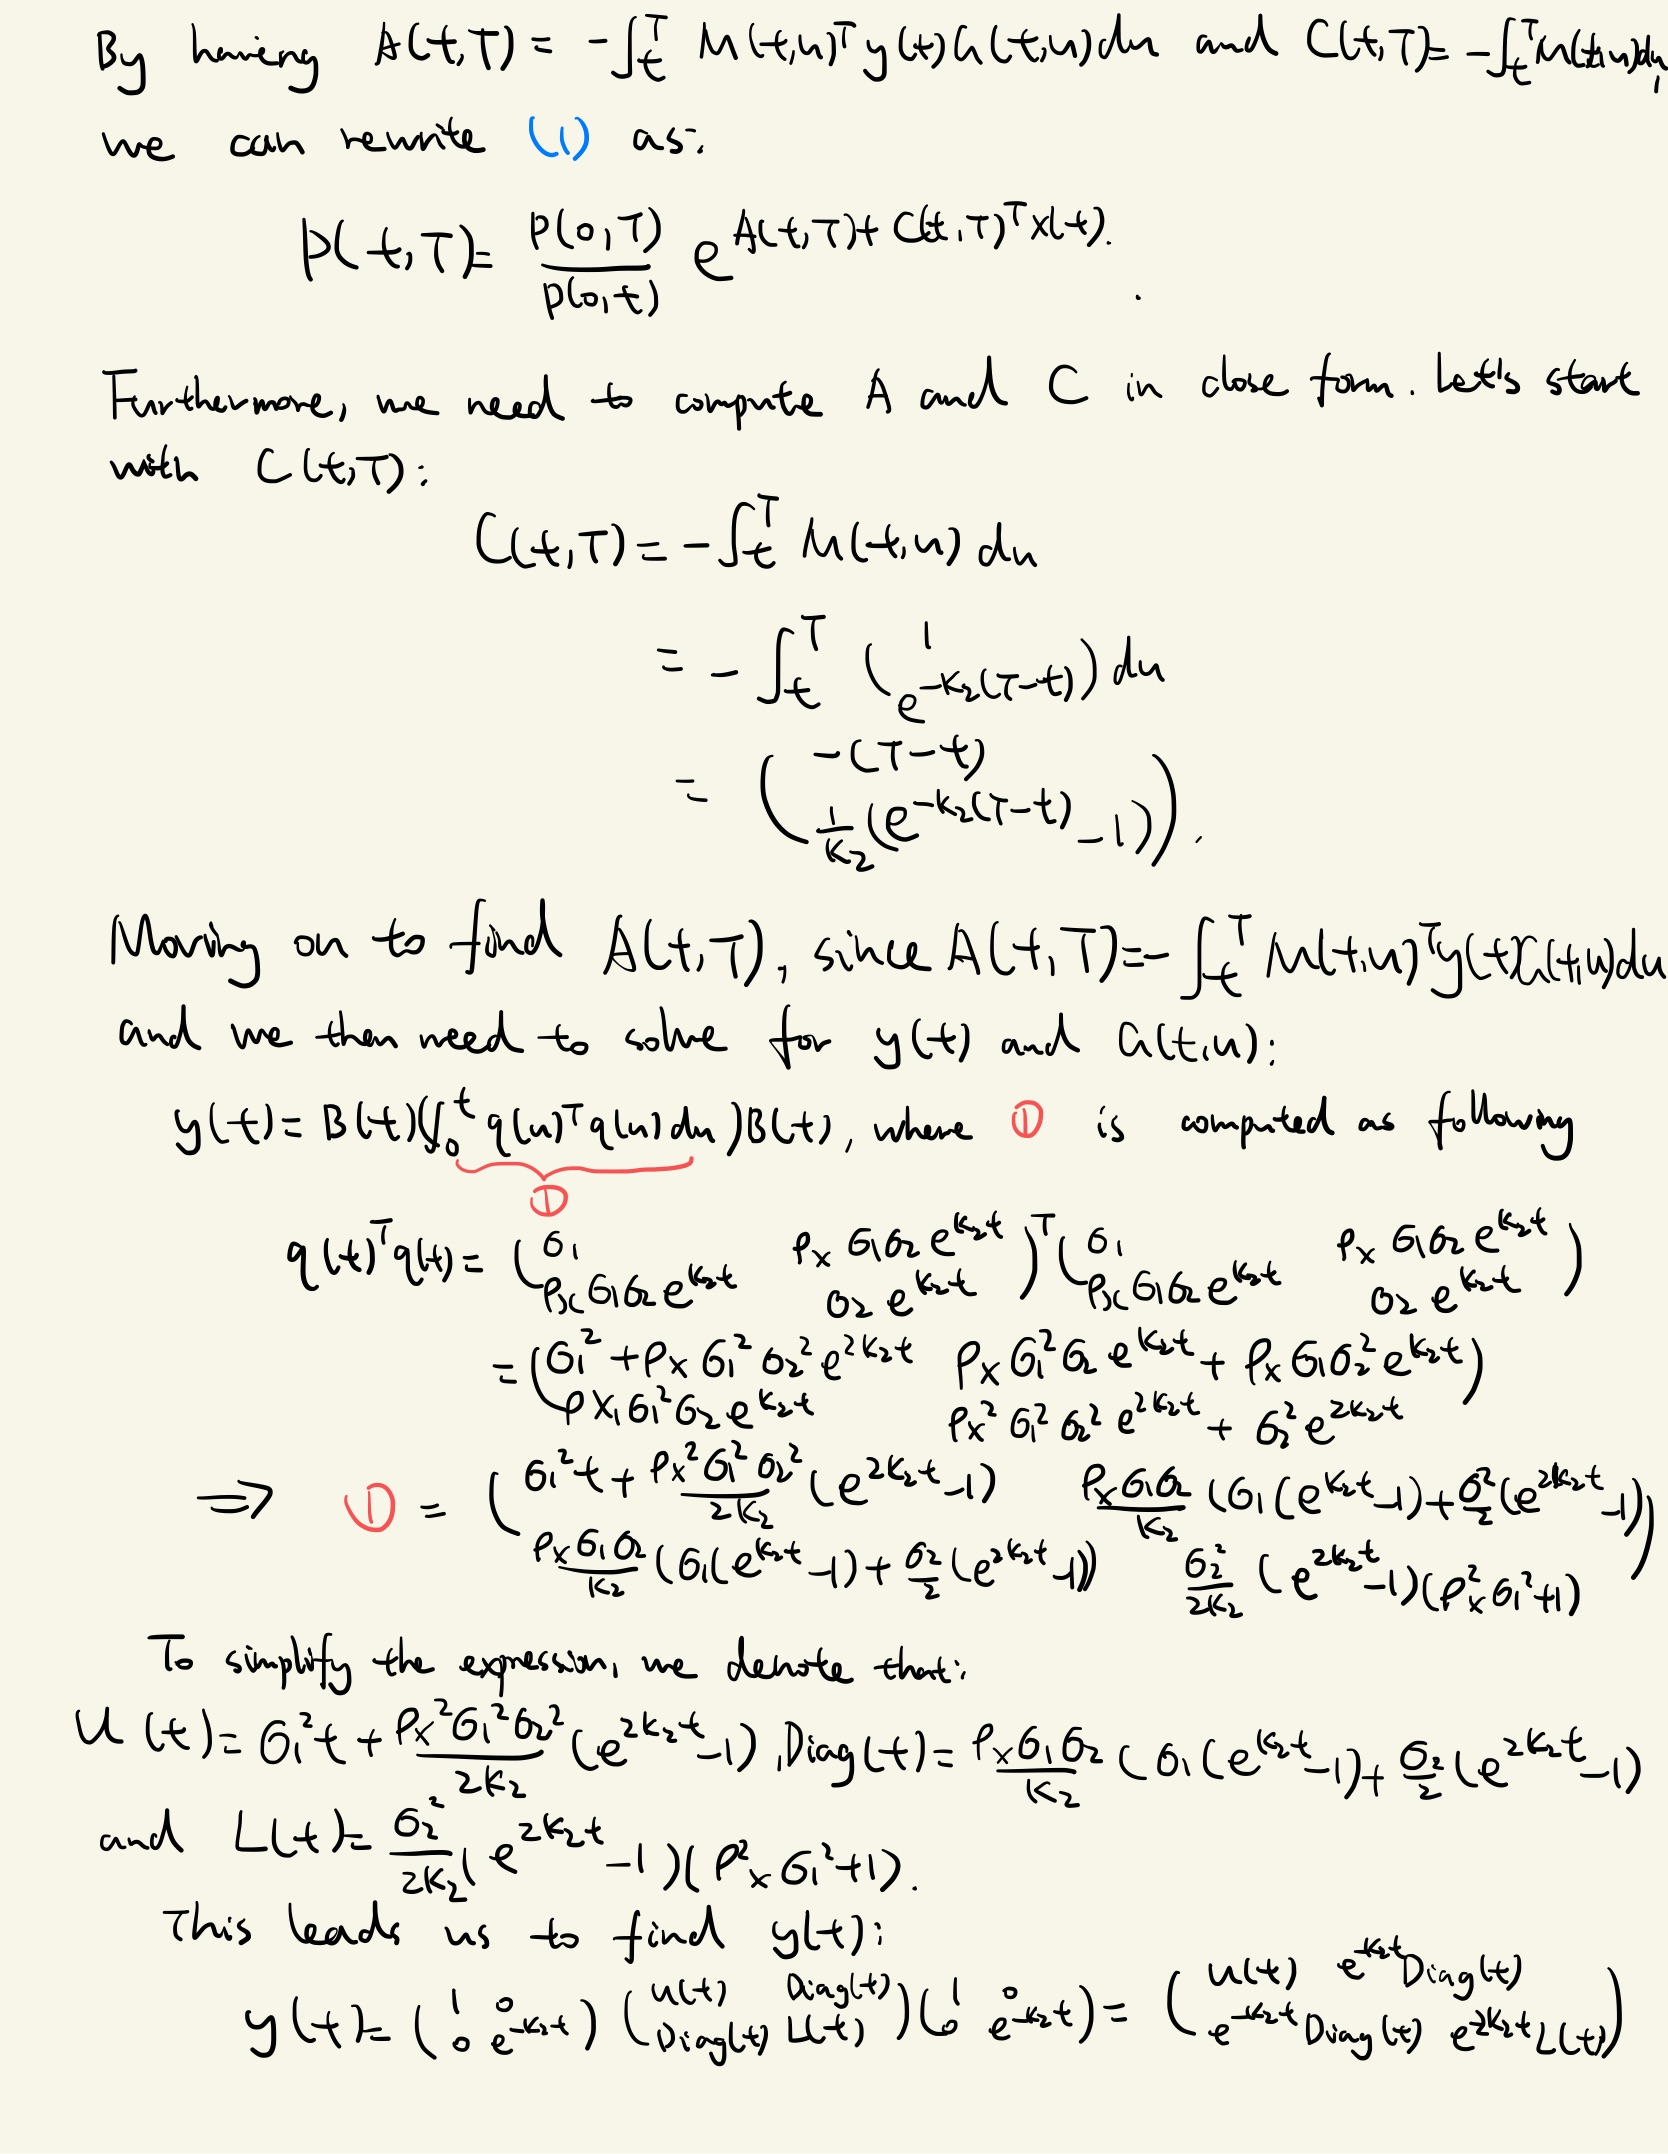

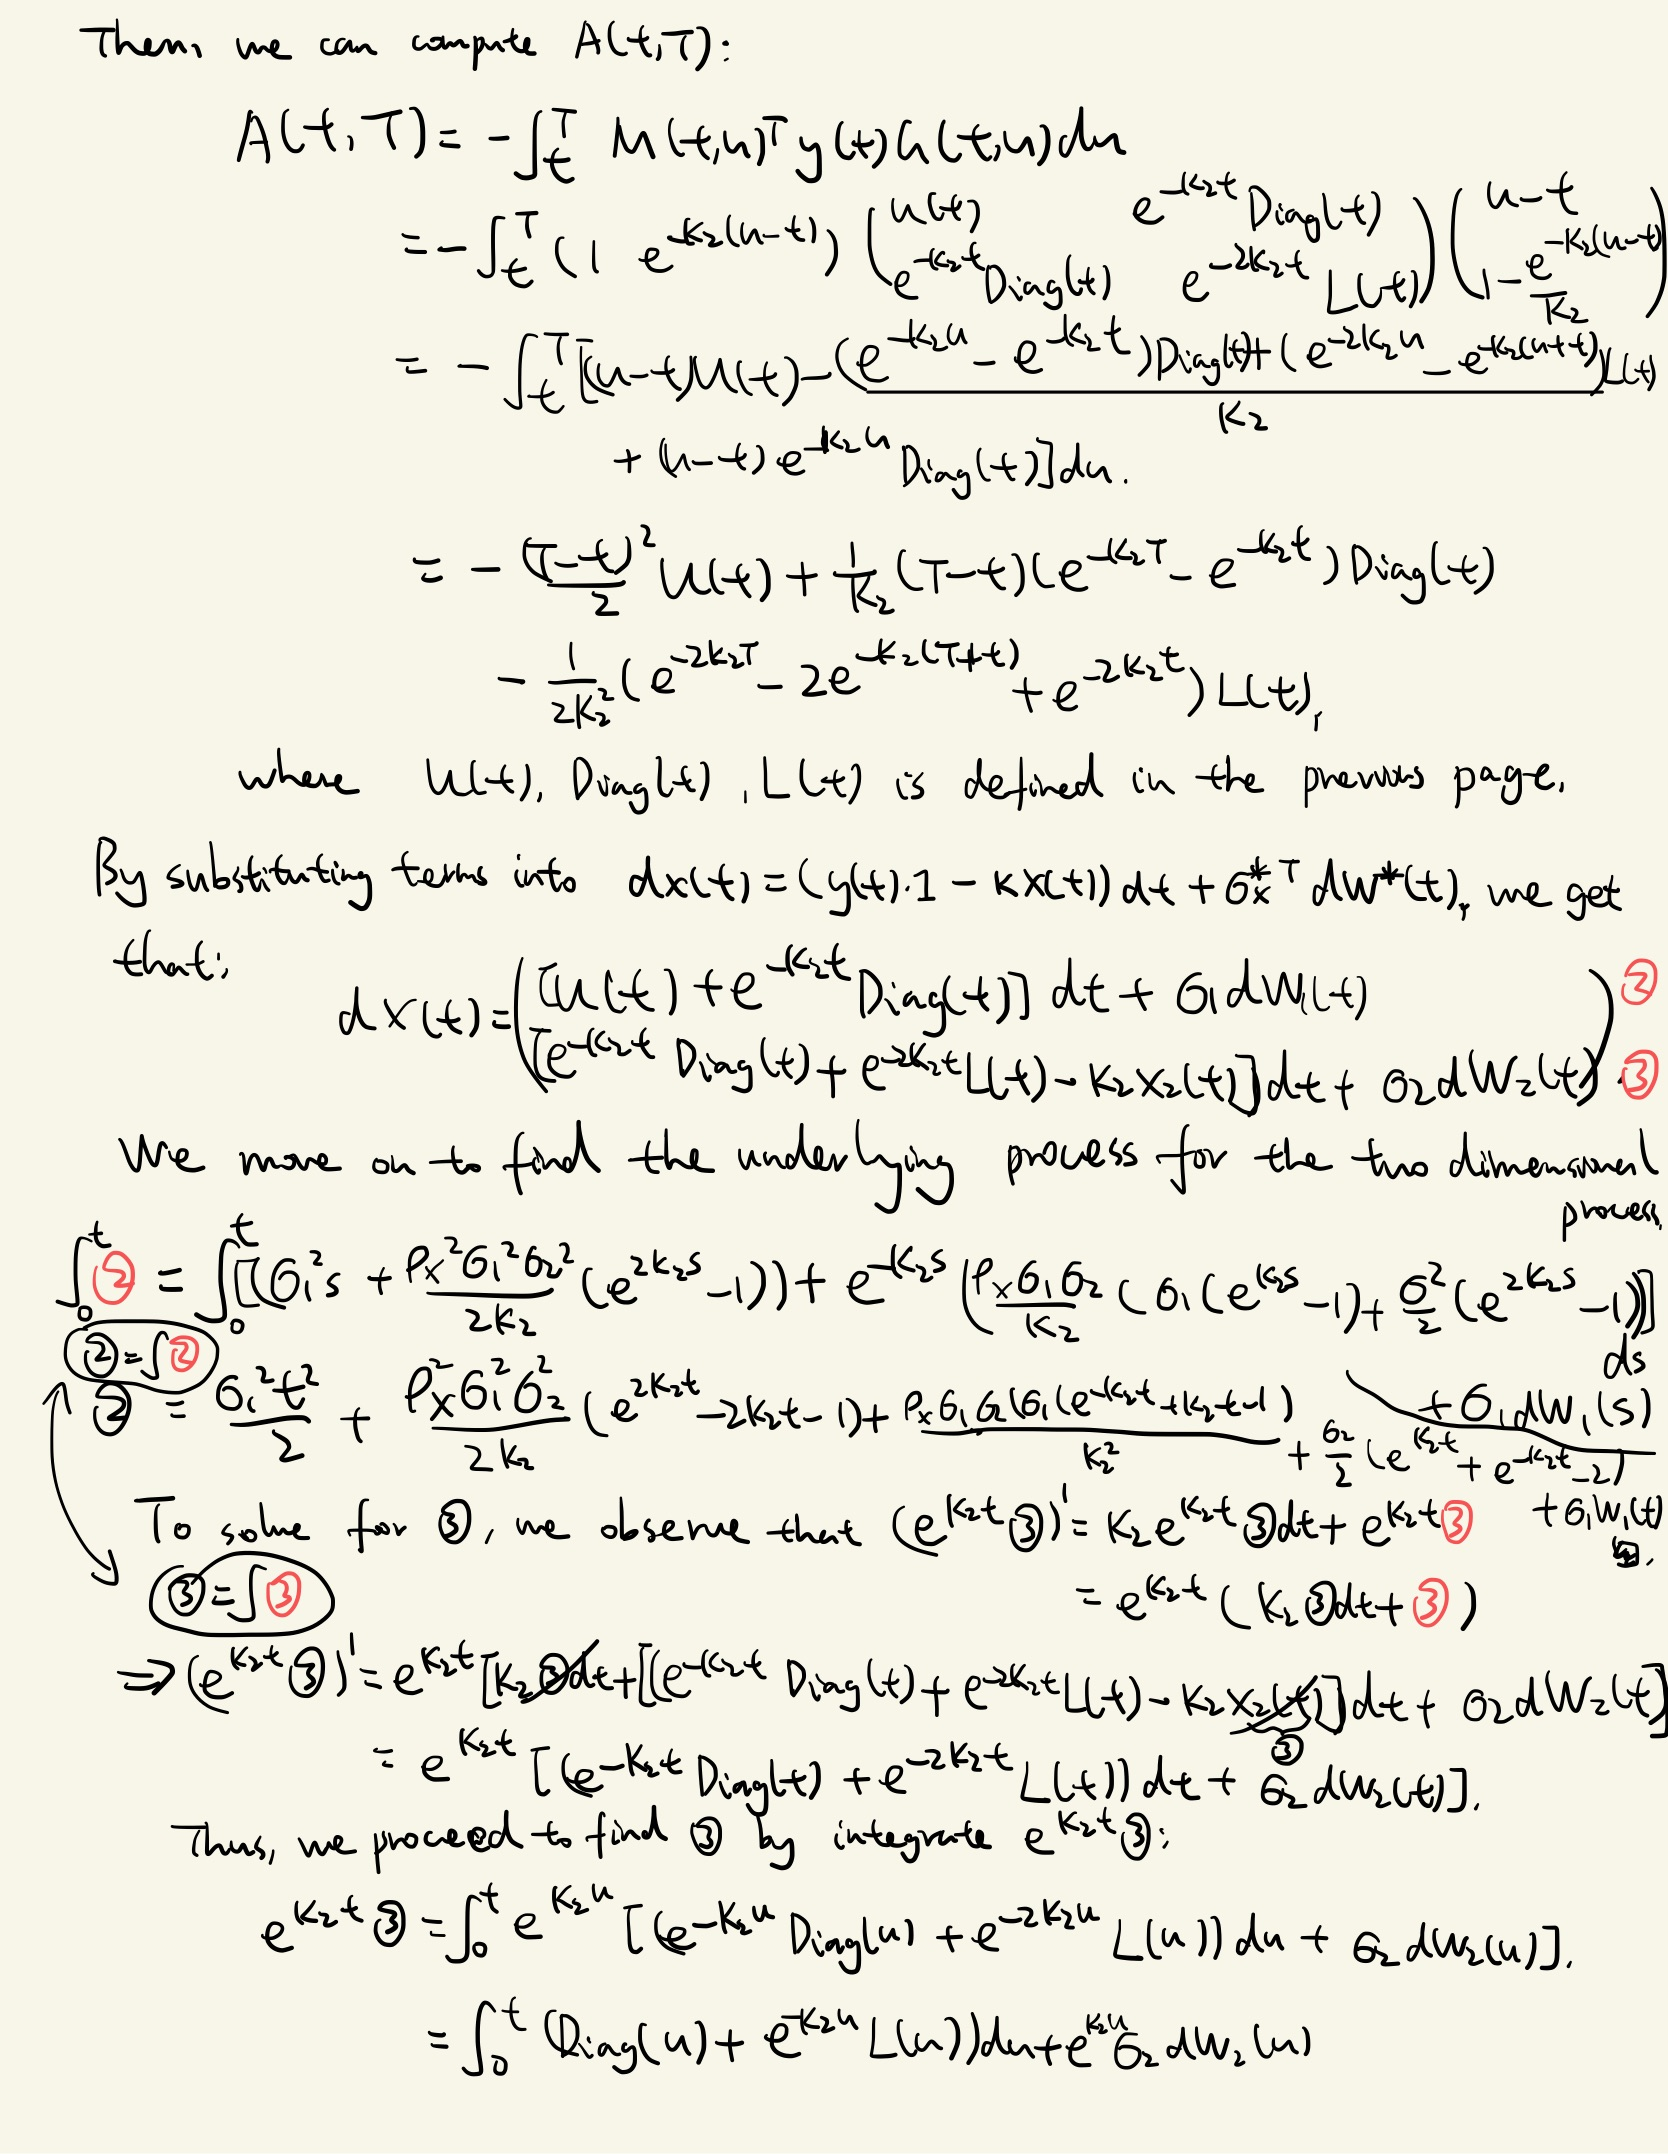

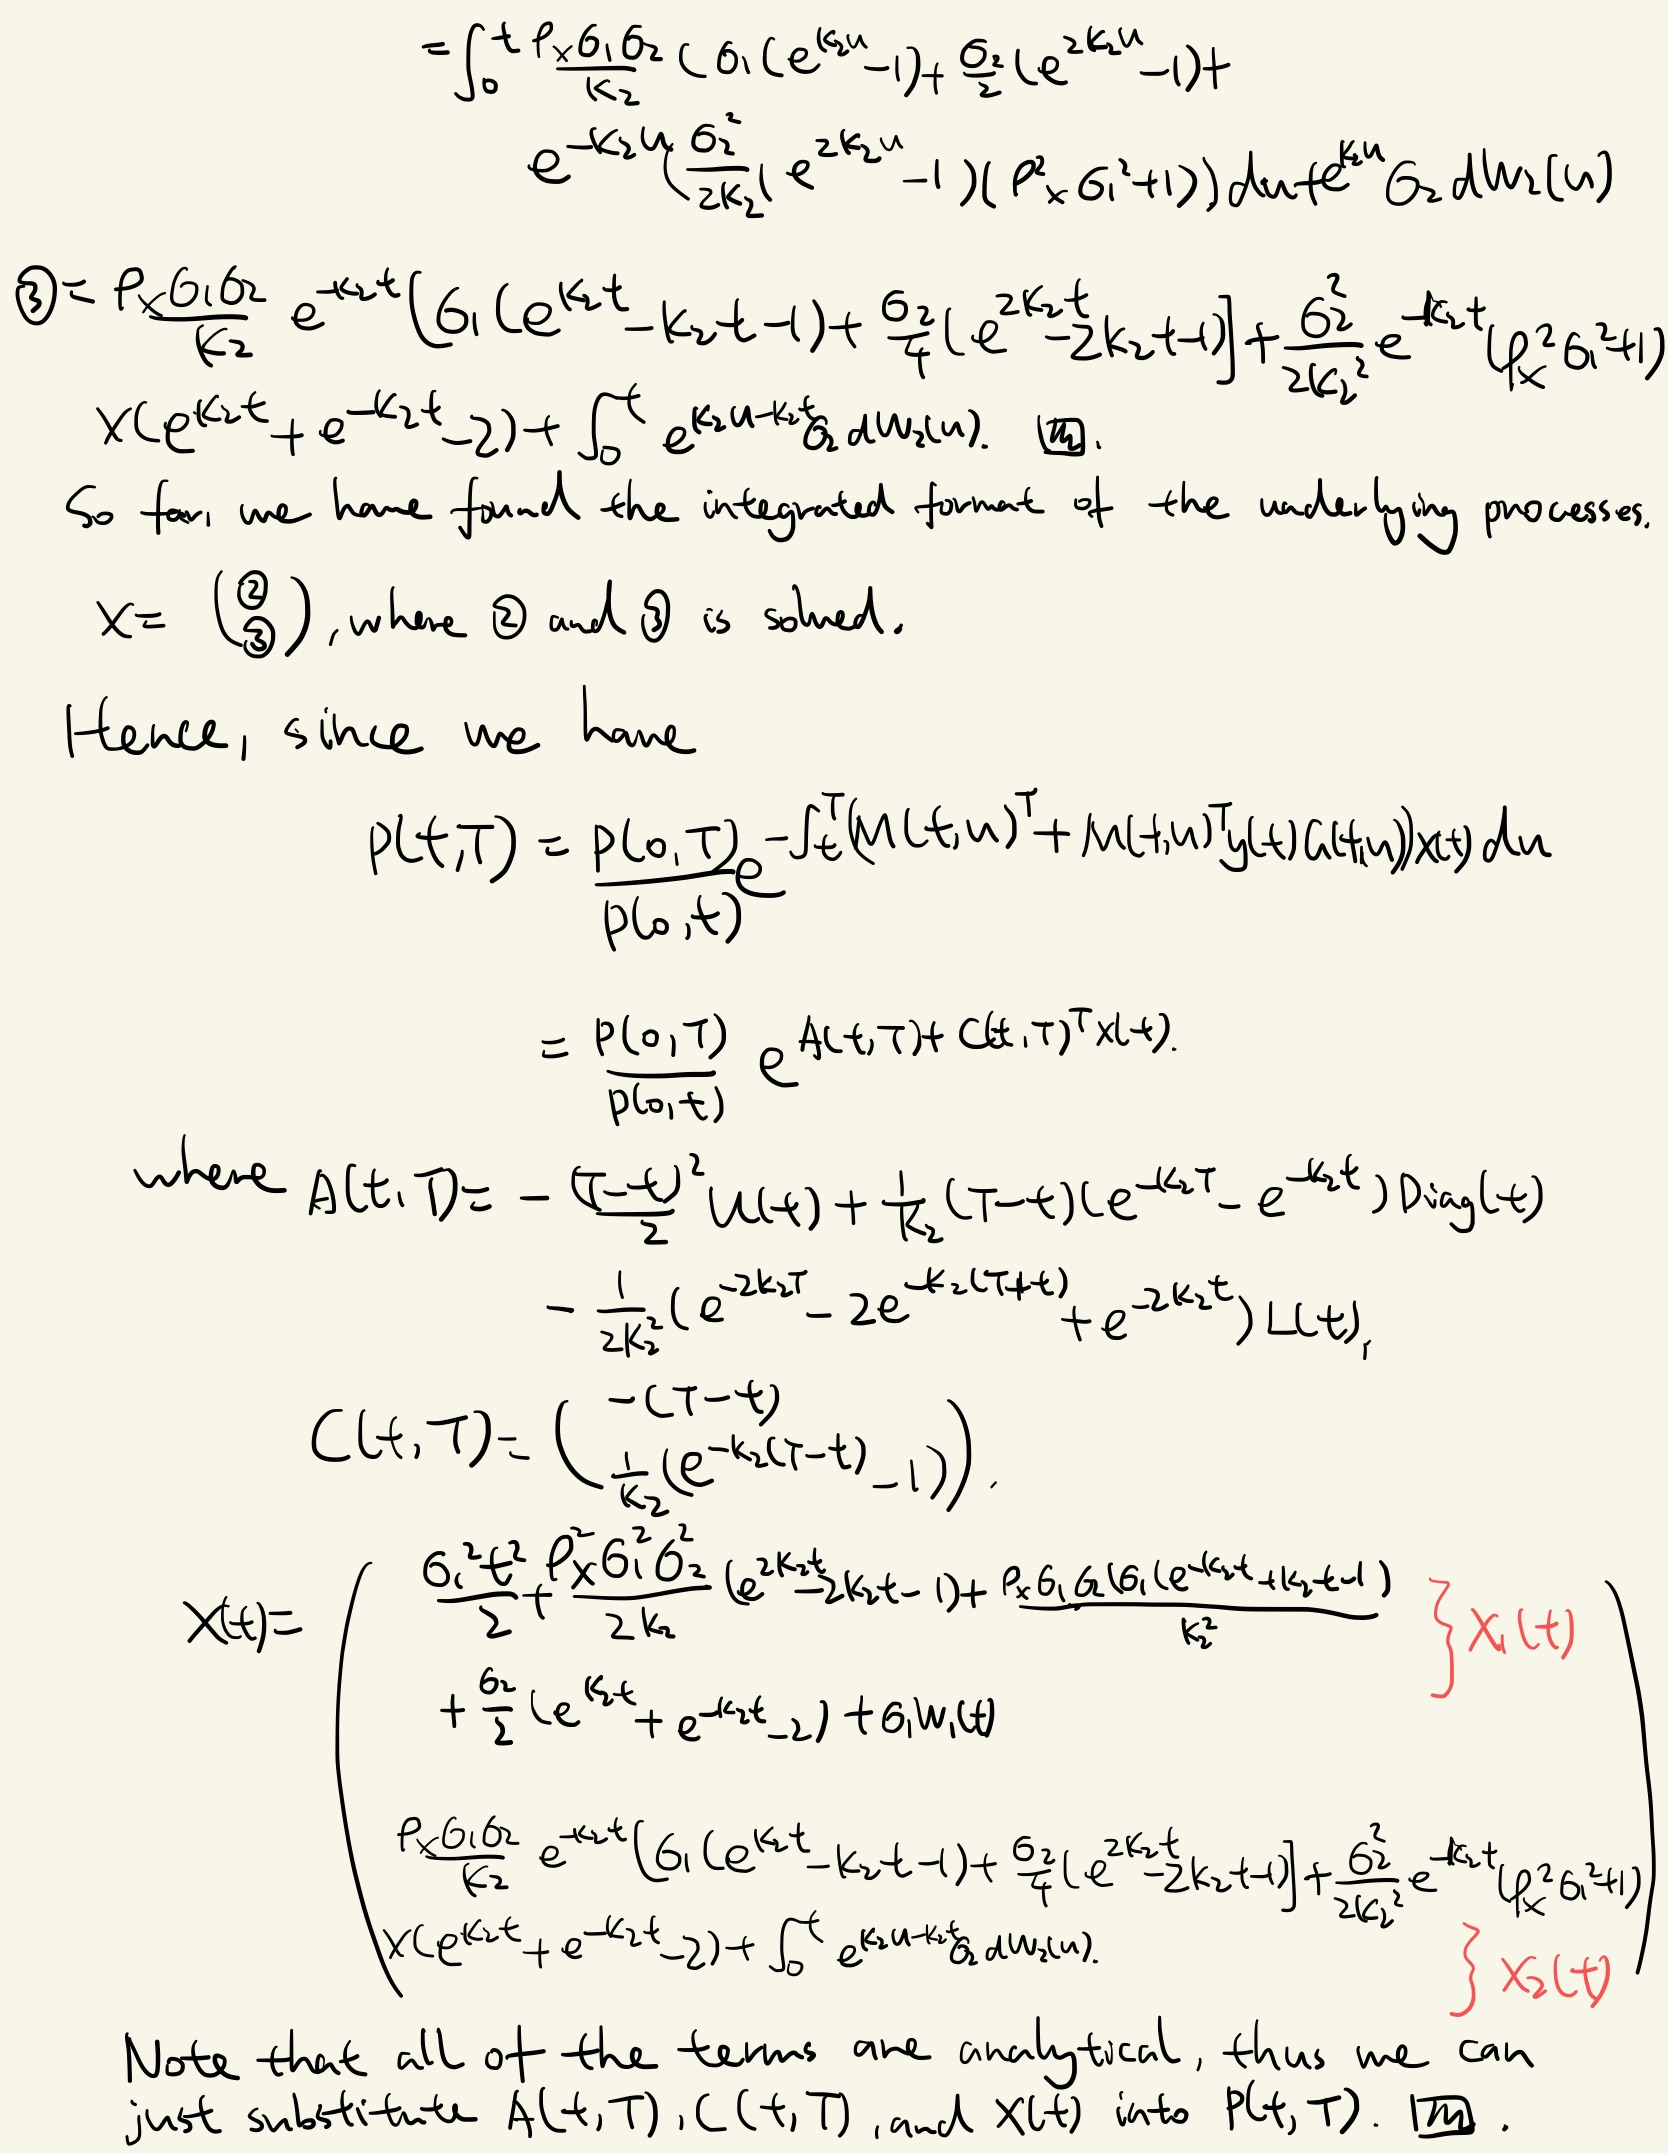

### Q3

The algorithm simulates the vector $x(t)$ to have a concrete expression for the reconstitution function. We generated stochasticity using Brownian motions and applied HJM models with Markov property. The increment of $x(t)$ is from the analytical part we drived from Q2, and following is our algorithm and sample $X_t$ paths.

In [2]:
# params setting
a = 0.025
b = 0.002
sigma_r = 0.02
c = 0.4
k2 = 0.05
rho_inf = 0.4

In [3]:
# model volatility quantities and correlation
sigma_1 = c*sigma_r
v = np.sqrt(c**(-2)-1-2*(rho_inf/c-1))
sigma_2 = sigma_1*v
rho_x = (rho_inf/c-1)/v

In [4]:
# simulate path for x1 and x2
def simulate_x(dt, T):
    time_span = np.linspace(0, T, T*int(1/dt)+1)
    x1 = [0]
    x2 = [0]
    
    def drift_x1(t):
        term1 = ((rho_x*sigma_1*sigma_2/k2/2)**2) * (np.exp(2*k2*t)-2*k2*t-1)
        term2 = (rho_x*sigma_1*sigma_2)/(k2**2) * \
                    (sigma_1*(np.exp(-k2*t)+k2*t-1)+sigma_2*(np.exp(k2*t)+np.exp(-k2*t)-2)/2)
        return (sigma_1*t)**2/2 + term1 + term2
    
    def drift_x2(t):
        term1 = (rho_x*sigma_1*sigma_2/(k2**2)*np.exp(-k2*t)) * \
                    (sigma_1*(np.exp(k2*t)-k2*t-1)+sigma_2*(np.exp(2*k2*t)-2*k2*t-1)/4)
        term2 = (sigma_2**2)/(2*k2*2)*np.exp(-k2*t) * ((rho_x*sigma_1)**2+1) * (np.exp(k2*t)+np.exp(-k2*t)-2)
        return term1 + term2
    
    for i in range(len(time_span)-1):
        dWt_1 = np.random.normal(0, np.sqrt(dt))
        dWt_2 = rho_x*dWt_1 + np.sqrt(1-rho_x**2)*np.random.normal(0, np.sqrt(dt))
        
        x1_diffusion = sigma_1*dWt_1
        x2_diffusion = sigma_2*np.exp(-k2*time_span[i])*dWt_2
        
        x1.append(x1[-1]+drift_x1(time_span[i+1])-drift_x1(time_span[i])+x1_diffusion)
        x2.append(x2[-1]+drift_x2(time_span[i+1])-drift_x2(time_span[i])+x2_diffusion)
        
    return x1, x2

In [5]:
# initialization
np.random.seed(99)
dt = 1/52
T = 10
num_paths = 10
time_span_motion = np.linspace(0, T, T*int(1/dt)+1)

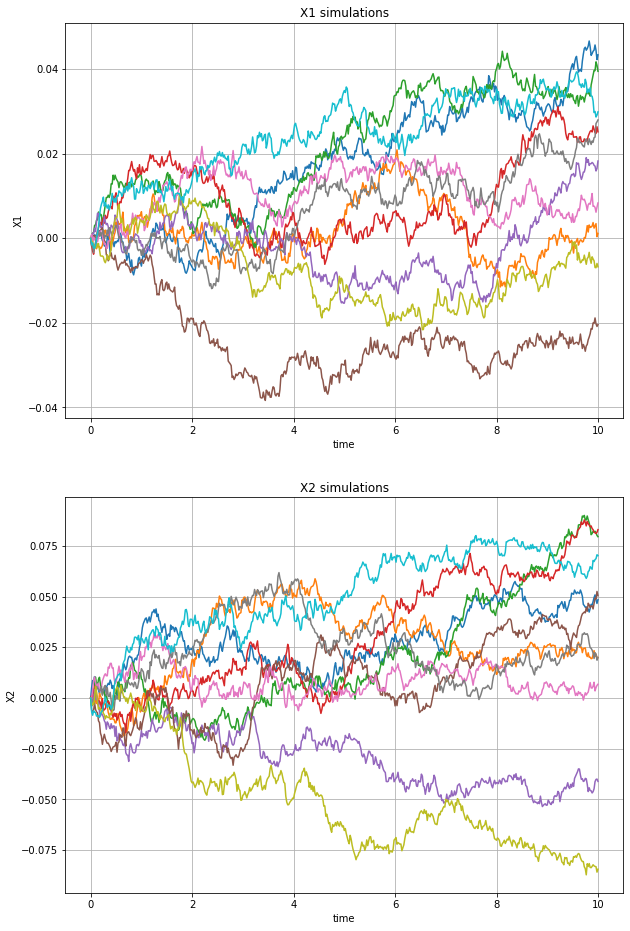

In [6]:
# 10 paths plots for x1 and x2
plt.figure(figsize=(10,16))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax1.set(xlabel='time', ylabel='X1', title='X1 simulations')
ax2.set(xlabel='time', ylabel='X2', title='X2 simulations')
ax1.grid()
ax2.grid()

x1s = []
x2s = []

for i in range(num_paths):
    x1, x2 = simulate_x(dt, T)
    x1s.append(x1)
    x2s.append(x2)
    ax1.plot(time_span_motion, x1)
    ax2.plot(time_span_motion, x2)

### Q4

In [7]:
notional = 5e7
# payment frequency
dt_4 = 1/2
T = 10
time_span_payment = np.linspace(0, T, T*int(1/dt_4)+1)

In [8]:
# apply Equation(3) from Lec7 note 
# for receiver swap we just need to flip the sign

def receiver_swap(h):
    value = 0
    def discount_factor(t, T):
        return np.exp(-a*(T-t) - (1/2)*b*(T-t)**2)
       
    for i in range(len(time_span_payment)-1):
        value += discount_factor(0, time_span_payment[i+1])*(1+h*dt_4) - \
                    discount_factor(0, time_span_payment[i+1]-dt_4)    
    return value * notional

In [9]:
h_range = np.linspace(0, 0.1, 101)
receiver_swap_values = [receiver_swap(h) for h in h_range]
payer_swap_values = [-v for v in receiver_swap_values]

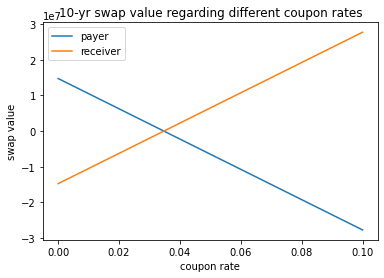

In [10]:
plt.plot(h_range, payer_swap_values, label = 'payer')
plt.plot(h_range, receiver_swap_values, label = 'receiver')
plt.xlabel('coupon rate')
plt.ylabel('swap value')
plt.title('10-yr swap value regarding different coupon rates')
plt.legend()

**To find the value of $h_{par}$ which makes both payer and receiver swap value equal to 0:**

In [11]:
h_par = fsolve(receiver_swap, 0)[0]
h_par

0.03472106682700023

### Q5

**Based on the result we get in Q2:**

$$
P(t, T)=\frac{P(0, T)}{P(0, t)} \exp \left(A(t, T)+C(t, T)^{\top} x(t)\right) \triangleq F(t, T, x(t))
$$
where
$$
G(t, T)=\left(\begin{array}{c}
(T-t) \\
-\frac{1}{\kappa_2}\left(e^{-\kappa_2(T-t)}-1\right)
\end{array}\right)
=-C(t, T)
$$
$$
A(t, T)=-\frac{1}{2} G(t, T)^T y(t) G(t, T)
$$
Then for the receiver swap value, the total payment at time $T_{i+1}$ is
$$
\begin{aligned}
V_{i+1}(t) &=(1+c \Delta) \mathrm{E}_t^{\mathbb{Q}}\left(\frac{\beta(t)}{\beta\left(T_{i+1}\right)}\right)-\mathrm{E}_t^{\mathbb{Q}}\left(\frac{\beta(t)}{\beta\left(T_i\right)}\right) \\
&=(1+c \Delta) P\left(t, T_{i+1}\right)-P\left(t, T_i\right)
\end{aligned}
$$

In [12]:
def y(t):
    first_layer = [t*sigma_1**2+(rho_x*sigma_1*sigma_2)**2*(np.exp(2*k2*t)-1)/(2*k2),
                  ((rho_x*sigma_1*sigma_2)/k2*(sigma_1*(np.exp(k2*t)-1)+sigma_2*(np.exp(2*k2*t)-1)/2))*np.exp(-k2*t)]
    second_layer = [first_layer[1],
                   (sigma_2**2*(np.exp(2*k2*t)-1)*((rho_x*sigma_1)**2+1)/(2*k2))*np.exp(-k2*2*t)]
    return np.array([first_layer, second_layer])

def G(t, T):
    first_layer = [T-t]
    second_layer = [-(np.exp(-k2*(T-t))-1)/k2]
    return np.array([first_layer, second_layer])

def A(t, T):
    return (-1/2)*((G(t,T).T) @ y(t) @ G(t,T))

def discount_factor(t, T):
    return np.exp(-a*(T-t) - (1/2)*b*(T-t)**2)

def F(t, T, x, dt):
    '''
    since we have done weekly spacing in Q3, and our swap makes payments semi-annually, so we need to transform
    yearly t to weekly
    '''
    discount = discount_factor(0, T)/discount_factor(0, t)
    return discount * np.exp(A(t, T)-G(t, T).T @ (x[:, int(t/dt)]))

def receiver_swap_q5(h, x, dt, dt_4):
    '''
    params:
       h: coupon rate
       x: simulated 2-d paths
       dt: time spacing for simulation
       dt_4: time spacing for payment
    '''
    result = []
    
    time_span_motion = np.linspace(0, T, T*int(1/dt)+1)
    time_span_payment = np.linspace(0, T, T*int(1/dt_4)+1)
    for i in range(len(time_span_motion)):
        value = 0
        # as discussed in the lec, T1 should be interpreted be the first remaining payment date after tj;
        # and T0 should be interpreted as the most recent swap payment date in the past.
        # so we consider 2 cases when current time is on a payment date or somewhere in between.
        if time_span_motion[i] in time_span_payment: 
            start = time_span_motion[i]
        else:
            # most recent
            start = np.floor(time_span_motion[i] + dt_4)
        
        time_span_temp = np.arange(start, 10.00001, dt_4)
        for T_temp in time_span_temp:
            value += ((1+dt_4*h)*F(time_span_motion[i], T_temp, x, dt) - \
                      F(time_span_motion[i], T_temp-dt_4, x, dt))[0][0]

        result.append(value*notional)
    return result 

In [13]:
dt = 1/52
dt_4 = 1/2

receiver_swap_values_q5 = []
payer_swap_values_q5 = []
for i in range(num_paths):
    receiver_swap_value = receiver_swap_q5(h_par, np.array([x1s[i], x2s[i]]), dt, dt_4)
    receiver_swap_values_q5.append(receiver_swap_value)
    payer_swap_values_q5.append([-v for v in receiver_swap_value])

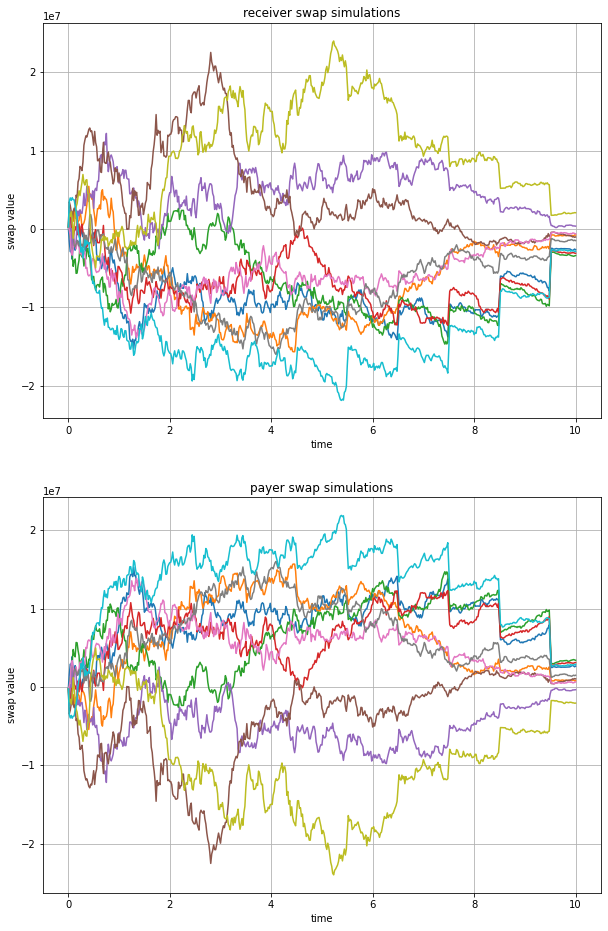

In [14]:
plt.figure(figsize=(10,16))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax1.set(xlabel='time', ylabel='swap value', title='receiver swap simulations')
ax2.set(xlabel='time', ylabel='swap value', title='payer swap simulations')
ax1.grid()
ax2.grid()

x1s = []
x2s = []

for i in range(num_paths):
    ax1.plot(time_span_motion, receiver_swap_values_q5[i])
    ax2.plot(time_span_motion, payer_swap_values_q5[i])

### Q6

In [15]:
# 48 buckets per year
dt_6 = 1/48
T = 10
num_simulation = 30000

In [16]:
# simulate the path of exposure
time_span_q6 = np.linspace(0, T, T*48+1)
x1s_q6 = []
x2s_q6 = []
for i in range(num_simulation):
    x1, x2 = simulate_x(dt_6, T)
    x1s_q6.append(x1)
    x2s_q6.append(x2)

In [17]:
receiver_swap_values_q6 = []
payer_swap_values_q6 = []
for i in range(num_simulation):
    receiver_swap_value = receiver_swap_q5(h_par, np.array([x1s_q6[i], x2s_q6[i]]), dt_6, dt_4)
    receiver_swap_values_q6.append(receiver_swap_value)
    payer_swap_values_q6.append([-v for v in receiver_swap_value])

In [18]:
EE_receiver = np.mean(np.clip(np.array(receiver_swap_values_q6), a_min = 0, a_max = None), axis=0)
EE_payer = np.mean(np.clip(np.array(payer_swap_values_q6), a_min = 0, a_max = None), axis=0)

Text(0.5, 1.0, 'receiver Swap EE Simulation')

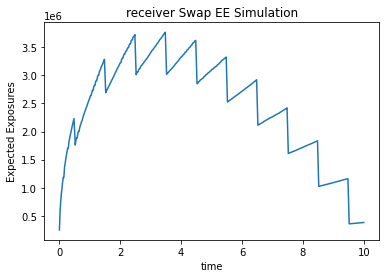

In [19]:
plt.plot(time_span_q6, EE_receiver)
plt.xlabel('time') 
plt.ylabel('Expected Exposures')
plt.title('receiver Swap EE Simulation')

Text(0.5, 1.0, 'Payer Swap EE Simulation')

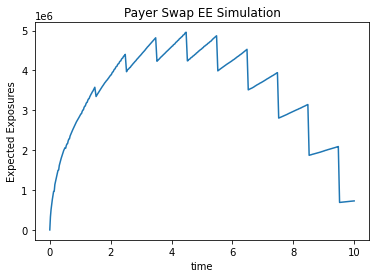

In [20]:
plt.plot(time_span_q6, EE_payer)
plt.xlabel('time') 
plt.ylabel('Expected Exposures')
plt.title('Payer Swap EE Simulation')